In [3]:
!mamba install pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings('ignore')



mambajs 0.19.13

Specs: xeus-python, numpy, matplotlib, pillow, ipywidgets>=8.1.6, ipyleaflet, scipy, geopandas, pandas
Channels: emscripten-forge, conda-forge

Solving environment...
Solving took 1.752199999988079 seconds
All requested packages already installed.


In [5]:
# 1. СОЗДАНИЕ СИНТЕТИЧЕСКОЙ ТЕРРИТОРИИ

print("="*80)
print("ЗАДАНИЕ 11: ЭКСПЕРТНЫЕ ПРАВИЛА И НЕЧЁТКАЯ ЛОГИКА")
print("="*80)
print("ОЦЕНКА ПРИГОДНОСТИ УЧАСТКА ПОД СОЛНЕЧНУЮ ЭЛЕКТРОСТАНЦИЮ")
print("="*80)

np.random.seed(42)

# Параметры территории
size = 50  # размер сетки 50x50 клеток
cell_size = 1  # размер клетки в км
total_area = size * cell_size  # общая площадь в км

# Создаём координатную сетку
x = np.linspace(0, total_area, size)
y = np.linspace(0, total_area, size)
X, Y = np.meshgrid(x, y)

print(f"\n ПАРАМЕТРЫ ТЕРРИТОРИИ:")
print(f"   Размер сетки: {size}x{size} клеток")
print(f"   Размер клетки: {cell_size} км")
print(f"   Общая площадь: {total_area} x {total_area} км ({total_area*total_area} км²)")

ЗАДАНИЕ 11: ЭКСПЕРТНЫЕ ПРАВИЛА И НЕЧЁТКАЯ ЛОГИКА
ОЦЕНКА ПРИГОДНОСТИ УЧАСТКА ПОД СОЛНЕЧНУЮ ЭЛЕКТРОСТАНЦИЮ

 ПАРАМЕТРЫ ТЕРРИТОРИИ:
   Размер сетки: 50x50 клеток
   Размер клетки: 1 км
   Общая площадь: 50 x 50 км (2500 км²)


In [6]:
# 2. ГЕНЕРАЦИЯ ФАКТОРОВ ПРИГОДНОСТИ

print("\n" + "="*80)
print("ГЕНЕРАЦИЯ ФАКТОРОВ ПРИГОДНОСТИ")
print("="*80)

# 2.1 УКЛОН (в градусах) - чем меньше, тем лучше
# Создаём рельеф с горами и равнинами
slope = np.zeros((size, size))

# Добавляем горный хребет (высокий уклон)
mountain_center_x, mountain_center_y = 30, 30
for i in range(size):
    for j in range(size):
        dist_to_mountain = np.sqrt((i - mountain_center_x)**2 + (j - mountain_center_y)**2)
        # Уклон увеличивается к горам
        mountain_slope = 15 * np.exp(-dist_to_mountain/15)
        # Равнины (малый уклон)
        plain_slope = 2 + 3 * np.random.random()
        
        # Комбинируем
        if dist_to_mountain < 25:
            slope[i, j] = mountain_slope + np.random.normal(0, 1)
        else:
            slope[i, j] = plain_slope + np.random.normal(0, 0.5)

# Гарантируем, что уклон в разумных пределах
slope = np.clip(slope, 0, 25)

print("\n УКЛОН (градусы):")
print(f"   Минимальный: {slope.min():.2f}°")
print(f"   Максимальный: {slope.max():.2f}°")
print(f"   Средний: {slope.mean():.2f}°")

# 2.2 ЭКСПОЗИЦИЯ (азимут склона) - южные склоны лучше
aspect = np.random.uniform(0, 360, (size, size))

# Добавляем структуру: южные склоны в определённых областях
for i in range(size):
    for j in range(size):
        if 20 < i < 40 and 20 < j < 40:
            # В этой области преобладают южные склоны
            aspect[i, j] = 180 + np.random.normal(0, 30)
        elif i < 20 and j > 30:
            # Северные склоны
            aspect[i, j] = 0 + np.random.normal(0, 30)

aspect = np.clip(aspect, 0, 360)

print("\n ЭКСПОЗИЦИЯ (градусы):")
print(f"   Минимальная: {aspect.min():.2f}°")
print(f"   Максимальная: {aspect.max():.2f}°")
print(f"   Средняя: {aspect.mean():.2f}°")

# 2.3 РАССТОЯНИЕ ДО ЛЭП (км) - чем ближе, тем лучше
dist_to_power = np.zeros((size, size))

# Добавляем линии ЛЭП (несколько точек)
power_lines = [
    (10, 10), (10, 40), (40, 10), (40, 40), (25, 25)
]

for i in range(size):
    for j in range(size):
        # Минимальное расстояние до любой ЛЭП
        min_dist = min(np.sqrt((i - pl[0])**2 + (j - pl[1])**2) for pl in power_lines)
        # Переводим в километры
        dist_to_power[i, j] = min_dist * cell_size + np.random.normal(0, 0.5)

dist_to_power = np.clip(dist_to_power, 0, 30)

print("\n РАССТОЯНИЕ ДО ЛЭП (км):")
print(f"   Минимальное: {dist_to_power.min():.2f} км")
print(f"   Максимальное: {dist_to_power.max():.2f} км")
print(f"   Среднее: {dist_to_power.mean():.2f} км")

# 2.4 ОХРАНЯЕМЫЕ ЗОНЫ (бинарно: 1 - охраняемая, 0 - нет)
protected = np.zeros((size, size))

# Добавляем охраняемые территории
# Национальный парк в центре
protected[20:30, 20:30] = 1
# Заповедник на юго-востоке
protected[35:45, 35:45] = 1
# Водоохранная зона
protected[5:15, 40:48] = 1

print("\n ОХРАНЯЕМЫЕ ЗОНЫ:")
print(f"   Площадь охраняемых зон: {np.sum(protected)} клеток ({np.sum(protected) * cell_size * cell_size} км²)")

# 2.5 ИНСОЛЯЦИЯ (солнечная радиация, кВт·ч/м²/день)
insolation = np.zeros((size, size))

# Инсоляция зависит от широты (чем южнее, тем больше) и облачности
for i in range(size):
    for j in range(size):
        # Базовое значение зависит от Y (широты)
        base = 4.5 - 0.02 * i + 0.5 * np.sin(j/10)
        # Облачность (случайная)
        clouds = np.random.normal(0, 0.3)
        # Влияние высоты (в горах больше солнца)
        height_effect = 0.01 * slope[i, j]
        
        insolation[i, j] = base + clouds + height_effect

insolation = np.clip(insolation, 3.0, 6.0)

print("\n ИНСОЛЯЦИЯ (кВт·ч/м²/день):")
print(f"   Минимальная: {insolation.min():.2f}")
print(f"   Максимальная: {insolation.max():.2f}")
print(f"   Средняя: {insolation.mean():.2f}")

# 2.6 ТИП ЗЕМЕЛЬ (бинарно: 1 - пригодные, 0 - непригодные)
land_use = np.ones((size, size))

# Лесные массивы (непригодны)
land_use[10:18, 30:38] = 0
land_use[40:48, 5:15] = 0
# Болота (непригодны)
land_use[25:30, 45:50] = 0
# Водные объекты (непригодны)
land_use[45:50, 20:25] = 0

print("\n ТИП ЗЕМЕЛЬ:")
print(f"   Пригодные земли: {np.sum(land_use)} клеток ({np.sum(land_use) * cell_size * cell_size} км²)")
print(f"   Непригодные земли: {size*size - np.sum(land_use)} клеток")


ГЕНЕРАЦИЯ ФАКТОРОВ ПРИГОДНОСТИ

 УКЛОН (градусы):
   Минимальный: 0.19°
   Максимальный: 14.83°
   Средний: 4.97°

 ЭКСПОЗИЦИЯ (градусы):
   Минимальная: 0.00°
   Максимальная: 359.77°
   Средняя: 151.25°

 РАССТОЯНИЕ ДО ЛЭП (км):
   Минимальное: 0.00 км
   Максимальное: 18.13 км
   Среднее: 8.81 км

 ОХРАНЯЕМЫЕ ЗОНЫ:
   Площадь охраняемых зон: 280.0 клеток (280.0 км²)

 ИНСОЛЯЦИЯ (кВт·ч/м²/день):
   Минимальная: 3.00
   Максимальная: 5.69
   Средняя: 4.13

 ТИП ЗЕМЕЛЬ:
   Пригодные земли: 2306.0 клеток (2306.0 км²)
   Непригодные земли: 194.0 клеток


In [7]:
# 3. ФУНКЦИИ ПРИНАДЛЕЖНОСТИ ДЛЯ НЕЧЁТКОЙ ЛОГИКИ

print("\n" + "="*80)
print("ФУНКЦИИ ПРИНАДЛЕЖНОСТИ (НЕЧЁТКАЯ ЛОГИКА)")
print("="*80)

def fuzzy_slope(s):
    """
    Функция принадлежности для уклона
    Чем меньше уклон, тем лучше
    """
    if s < 3:
        return 1.0
    elif s < 8:
        return 1.0 - (s - 3) / 5
    elif s < 15:
        return 0.3 - (s - 8) / 35
    else:
        return 0.0

def fuzzy_aspect(a):
    """
    Функция принадлежности для экспозиции
    Южные склоны (150-210°) лучше всего
    """
    if 150 <= a <= 210:
        return 1.0
    elif 120 <= a < 150:
        return (a - 120) / 30
    elif 210 < a <= 240:
        return (240 - a) / 30
    elif 90 <= a < 120:
        return (a - 90) / 60
    elif 240 < a <= 270:
        return (270 - a) / 60
    else:
        return 0.2  # минимальная пригодность

def fuzzy_dist_power(d, max_dist=20):
    """
    Функция принадлежности для расстояния до ЛЭП
    Чем ближе к ЛЭП, тем лучше
    """
    if d < 2:
        return 1.0
    elif d < 10:
        return 1.0 - (d - 2) / 8
    elif d < 20:
        return 0.3 - (d - 10) / 50
    else:
        return 0.1

def fuzzy_protected(p):
    """
    Функция принадлежности для охраняемых зон
    Охраняемые зоны непригодны
    """
    return 0.0 if p > 0.5 else 1.0

def fuzzy_land_use(l):
    """
    Функция принадлежности для типа земель
    """
    return 1.0 if l > 0.5 else 0.0

def fuzzy_insolation(i, min_i=3.5, max_i=5.5):
    """
    Функция принадлежности для инсоляции
    """
    if i > 5.0:
        return 1.0
    elif i > 4.0:
        return 0.5 + (i - 4.0) / 2
    elif i > 3.0:
        return (i - 3.0) / 2
    else:
        return 0.0

print("\n   Функции принадлежности определены")


ФУНКЦИИ ПРИНАДЛЕЖНОСТИ (НЕЧЁТКАЯ ЛОГИКА)

   Функции принадлежности определены


In [8]:
# 4. РАСЧЁТ ИНТЕГРАЛЬНОЙ ПРИГОДНОСТИ

print("\n" + "="*80)
print("РАСЧЁТ ИНТЕГРАЛЬНОЙ ПРИГОДНОСТИ")
print("="*80)

# Веса факторов (экспертные оценки)
weights = {
    'slope': 0.25,      # уклон
    'aspect': 0.10,     # экспозиция
    'dist_power': 0.20, # расстояние до ЛЭП
    'protected': 0.15,  # охраняемые зоны
    'land_use': 0.15,   # тип земель
    'insolation': 0.15  # инсоляция
}

print("\n ВЕСА ФАКТОРОВ:")
for factor, weight in weights.items():
    print(f"   {factor}: {weight}")

# Расчёт пригодности для каждой клетки
suitability = np.zeros((size, size))
membership_values = {
    'slope': np.zeros((size, size)),
    'aspect': np.zeros((size, size)),
    'dist_power': np.zeros((size, size)),
    'protected': np.zeros((size, size)),
    'land_use': np.zeros((size, size)),
    'insolation': np.zeros((size, size))
}

for i in range(size):
    for j in range(size):
        # Вычисляем значения принадлежности
        m_slope = fuzzy_slope(slope[i, j])
        m_aspect = fuzzy_aspect(aspect[i, j])
        m_dist = fuzzy_dist_power(dist_to_power[i, j])
        m_prot = fuzzy_protected(protected[i, j])
        m_land = fuzzy_land_use(land_use[i, j])
        m_insol = fuzzy_insolation(insolation[i, j])
        
        # Сохраняем для анализа
        membership_values['slope'][i, j] = m_slope
        membership_values['aspect'][i, j] = m_aspect
        membership_values['dist_power'][i, j] = m_dist
        membership_values['protected'][i, j] = m_prot
        membership_values['land_use'][i, j] = m_land
        membership_values['insolation'][i, j] = m_insol
        
        # Взвешенная сумма (среднее арифметическое)
        suitability[i, j] = (weights['slope'] * m_slope +
                            weights['aspect'] * m_aspect +
                            weights['dist_power'] * m_dist +
                            weights['protected'] * m_prot +
                            weights['land_use'] * m_land +
                            weights['insolation'] * m_insol)

# Применяем жёсткие ограничения
# Если земля непригодна или охраняемая зона - пригодность 0
hard_constraints = (land_use < 0.5) | (protected > 0.5)
suitability[hard_constraints] = 0

print("\n ИНТЕГРАЛЬНАЯ ПРИГОДНОСТЬ:")
print(f"   Минимальная: {suitability.min():.3f}")
print(f"   Максимальная: {suitability.max():.3f}")
print(f"   Средняя: {suitability.mean():.3f}")
print(f"   Медианная: {np.median(suitability):.3f}")



РАСЧЁТ ИНТЕГРАЛЬНОЙ ПРИГОДНОСТИ

 ВЕСА ФАКТОРОВ:
   slope: 0.25
   aspect: 0.1
   dist_power: 0.2
   protected: 0.15
   land_use: 0.15
   insolation: 0.15

 ИНТЕГРАЛЬНАЯ ПРИГОДНОСТЬ:
   Минимальная: 0.000
   Максимальная: 0.963
   Средняя: 0.534
   Медианная: 0.627


In [9]:
# 5. КЛАССИФИКАЦИЯ ПРИГОДНОСТИ

print("\n" + "="*80)
print("КЛАССИФИКАЦИЯ ПРИГОДНОСТИ")
print("="*80)

# Создаём категории пригодности
suitability_class = np.zeros((size, size), dtype=int)
suitability_class[suitability >= 0.7] = 3  # высокая
suitability_class[(suitability >= 0.5) & (suitability < 0.7)] = 2  # средняя
suitability_class[(suitability >= 0.3) & (suitability < 0.5)] = 1  # низкая
suitability_class[suitability < 0.3] = 0  # непригодно

class_counts = {
    0: np.sum(suitability_class == 0),
    1: np.sum(suitability_class == 1),
    2: np.sum(suitability_class == 2),
    3: np.sum(suitability_class == 3)
}

print("\n РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:")
print(f"   3 - Высокая пригодность (>0.7): {class_counts[3]} клеток ({class_counts[3] * cell_size * cell_size:.0f} км²)")
print(f"   2 - Средняя пригодность (0.5-0.7): {class_counts[2]} клеток ({class_counts[2] * cell_size * cell_size:.0f} км²)")
print(f"   1 - Низкая пригодность (0.3-0.5): {class_counts[1]} клеток ({class_counts[1] * cell_size * cell_size:.0f} км²)")
print(f"   0 - Непригодно (<0.3): {class_counts[0]} клеток ({class_counts[0] * cell_size * cell_size:.0f} км²)")


КЛАССИФИКАЦИЯ ПРИГОДНОСТИ

 РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:
   3 - Высокая пригодность (>0.7): 693 клеток (693 км²)
   2 - Средняя пригодность (0.5-0.7): 1222 клеток (1222 км²)
   1 - Низкая пригодность (0.3-0.5): 111 клеток (111 км²)
   0 - Непригодно (<0.3): 474 клеток (474 км²)


In [11]:
# 6. ПОИСК ПОГРАНИЧНЫХ СЛУЧАЕВ

print("\n" + "="*80)
print("ПОИСК ПОГРАНИЧНЫХ СЛУЧАЕВ")
print("="*80)

# Находим клетки со средней пригодностью (0.4-0.6)
borderline_mask = (suitability >= 0.4) & (suitability < 0.6) & ~hard_constraints
borderline_indices = np.where(borderline_mask)
borderline_count = len(borderline_indices[0])

print(f"\n НАЙДЕНО ПОГРАНИЧНЫХ КЛЕТОК: {borderline_count}")

if borderline_count > 0:
    print("\n   ПРИМЕРЫ ПОГРАНИЧНЫХ КЛЕТОК:")
    # Покажем до 5 примеров
    n_examples = min(5, borderline_count)
    for k in range(n_examples):
        i = borderline_indices[0][k]
        j = borderline_indices[1][k]
        
        print(f"\n   Клетка [{i}, {j}] (коорд. {i*cell_size:.0f}, {j*cell_size:.0f} км):")
        print(f"      Уклон: {slope[i, j]:.2f}° -> принадлежность {membership_values['slope'][i, j]:.3f}")
        print(f"      Экспозиция: {aspect[i, j]:.2f}° -> принадлежность {membership_values['aspect'][i, j]:.3f}")
        print(f"      Расстояние до ЛЭП: {dist_to_power[i, j]:.2f} км -> принадлежность {membership_values['dist_power'][i, j]:.3f}")
        print(f"      Охраняемая зона: {protected[i, j]} -> принадлежность {membership_values['protected'][i, j]:.3f}")
        print(f"      Тип земель: {land_use[i, j]} -> принадлежность {membership_values['land_use'][i, j]:.3f}")
        print(f"      Инсоляция: {insolation[i, j]:.2f} -> принадлежность {membership_values['insolation'][i, j]:.3f}")
        print(f"      ИТОГОВАЯ ПРИГОДНОСТЬ: {suitability[i, j]:.3f}")


ПОИСК ПОГРАНИЧНЫХ СЛУЧАЕВ

 НАЙДЕНО ПОГРАНИЧНЫХ КЛЕТОК: 586

   ПРИМЕРЫ ПОГРАНИЧНЫХ КЛЕТОК:

   Клетка [0, 38] (коорд. 0, 38 км):
      Уклон: 5.03° -> принадлежность 0.594
      Экспозиция: 0.00° -> принадлежность 0.200
      Расстояние до ЛЭП: 9.64 км -> принадлежность 0.045
      Охраняемая зона: 0.0 -> принадлежность 1.000
      Тип земель: 1.0 -> принадлежность 1.000
      Инсоляция: 4.15 -> принадлежность 0.577
      ИТОГОВАЯ ПРИГОДНОСТЬ: 0.564

   Клетка [0, 43] (коорд. 0, 43 км):
      Уклон: 4.05° -> принадлежность 0.791
      Экспозиция: 0.00° -> принадлежность 0.200
      Расстояние до ЛЭП: 9.92 км -> принадлежность 0.010
      Охраняемая зона: 0.0 -> принадлежность 1.000
      Тип земель: 1.0 -> принадлежность 1.000
      Инсоляция: 3.70 -> принадлежность 0.350
      ИТОГОВАЯ ПРИГОДНОСТЬ: 0.572

   Клетка [0, 48] (коорд. 0, 48 км):
      Уклон: 5.04° -> принадлежность 0.592
      Экспозиция: 17.97° -> принадлежность 0.200
      Расстояние до ЛЭП: 13.45 км -> принадлежность


ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ


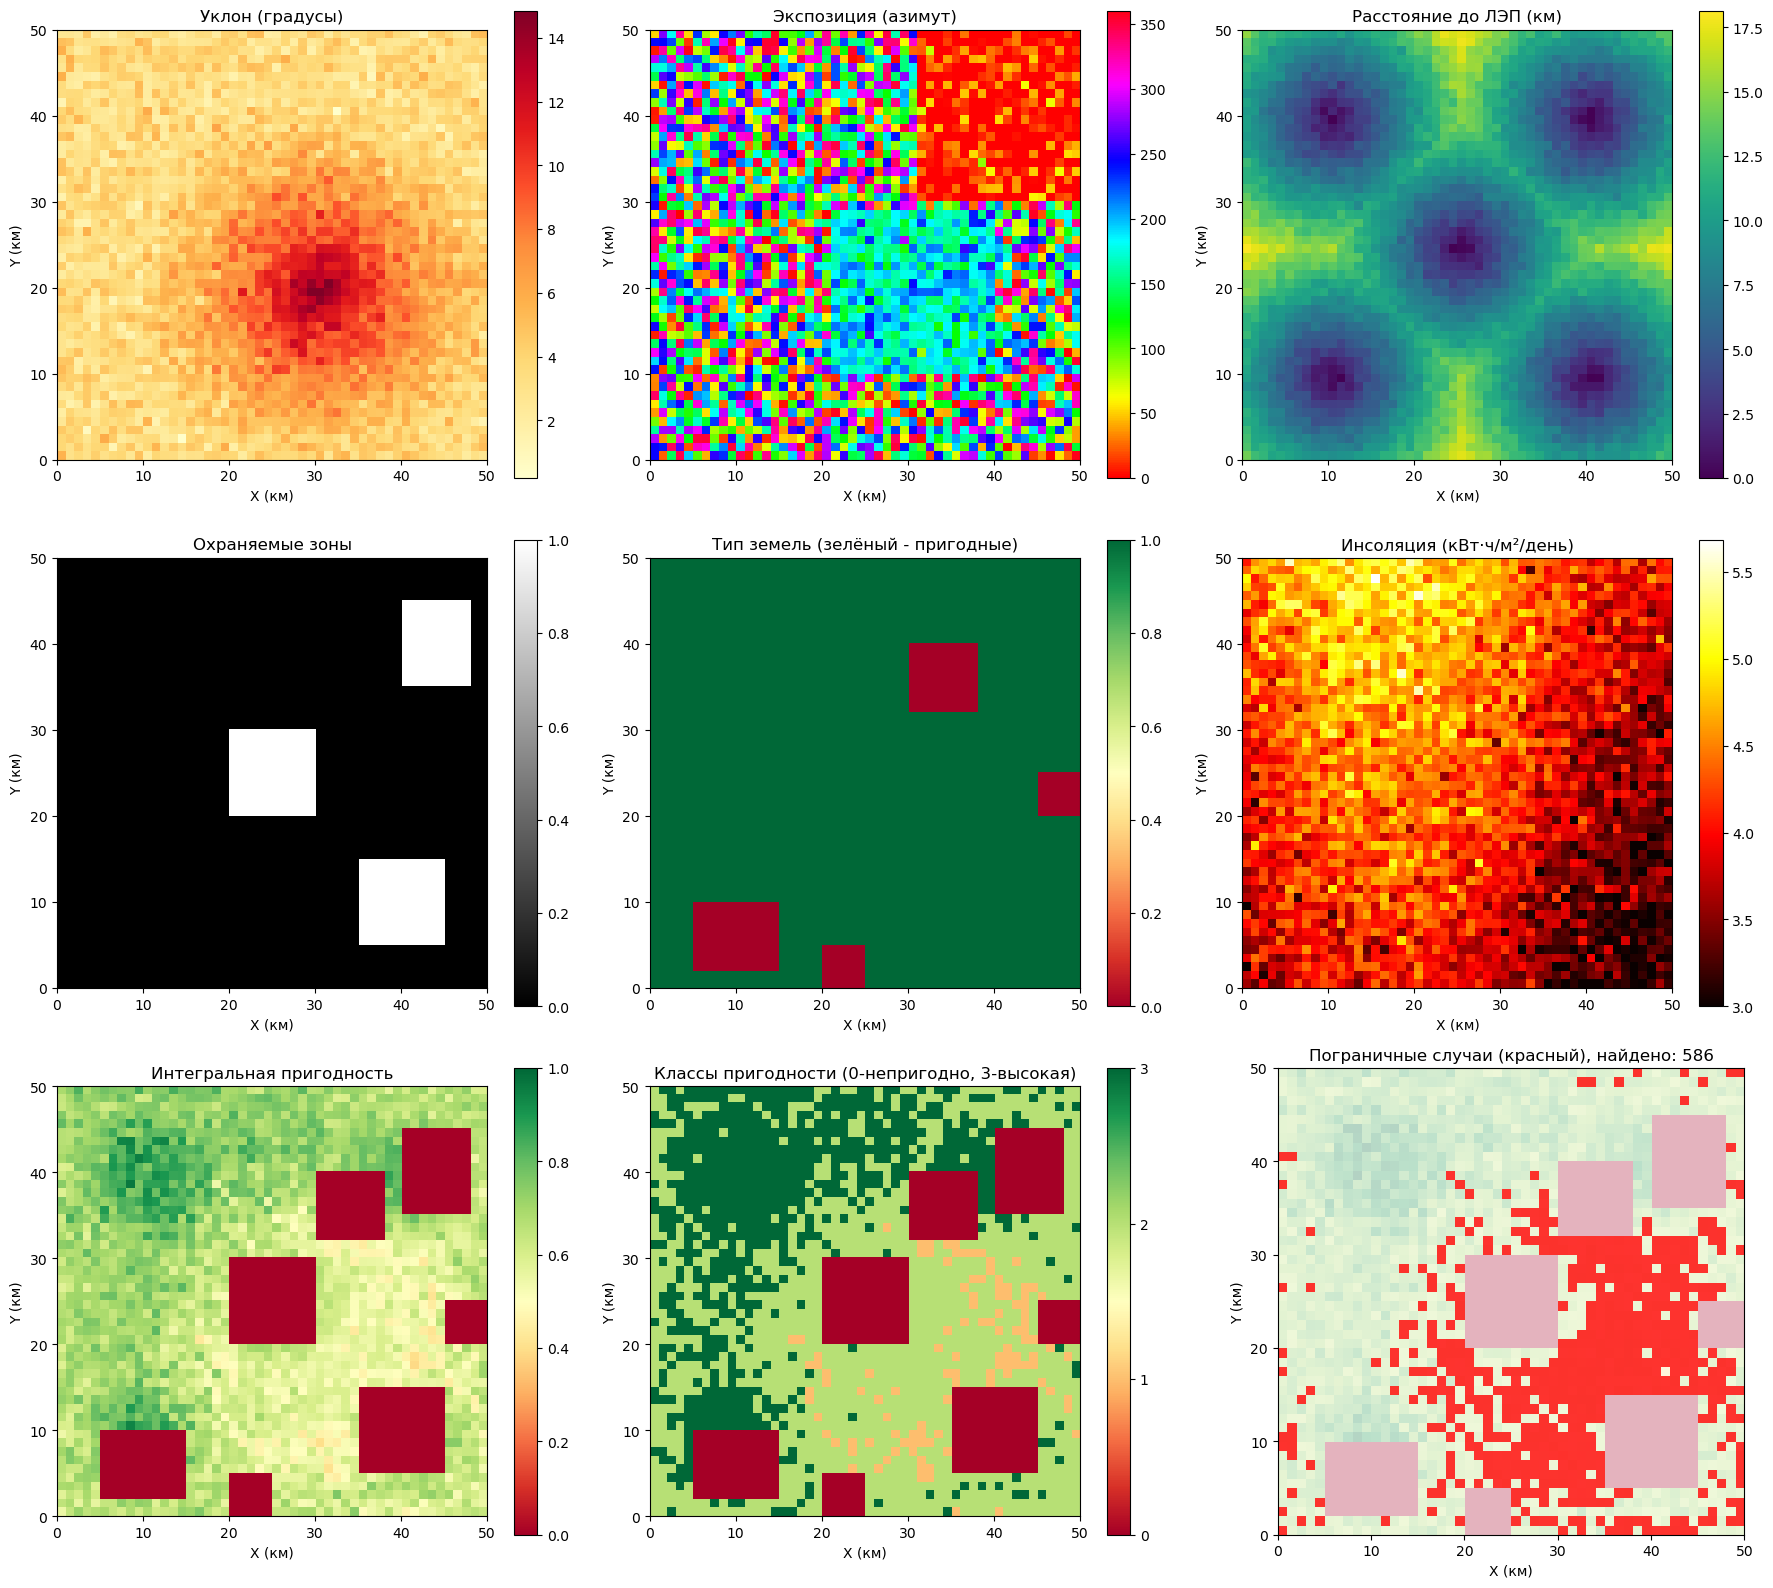

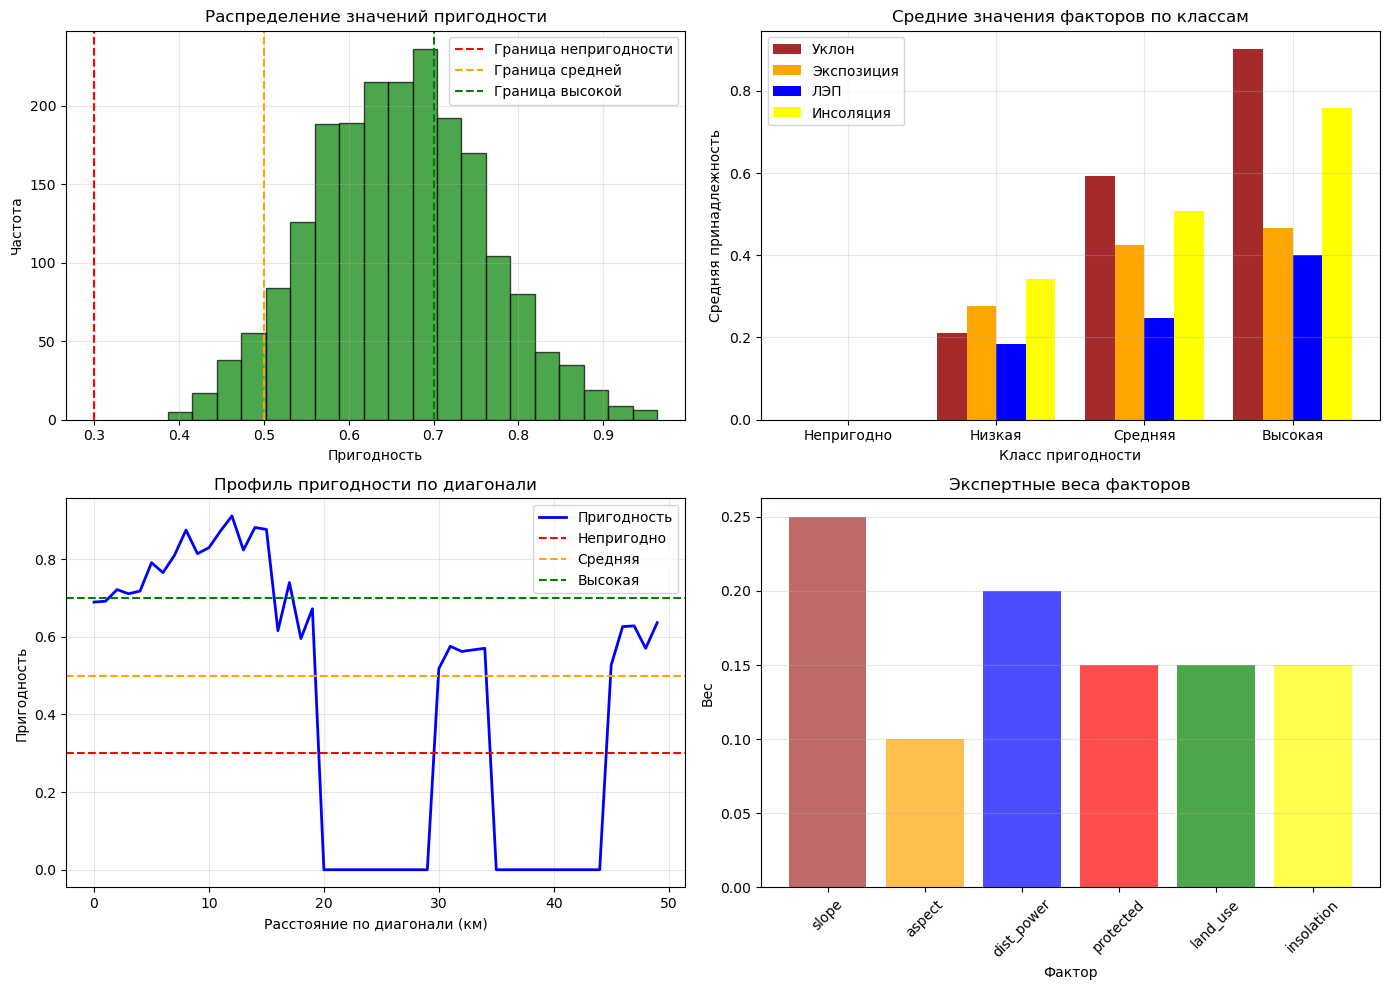

In [12]:
# 7. ВИЗУАЛИЗАЦИЯ

print("\n" + "="*80)
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*80)

fig, axes = plt.subplots(3, 3, figsize=(18, 16))

# 1. Уклон
ax = axes[0, 0]
im1 = ax.imshow(slope, cmap='YlOrRd', extent=[0, total_area, 0, total_area])
ax.set_title('Уклон (градусы)')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im1, ax=ax)

# 2. Экспозиция
ax = axes[0, 1]
im2 = ax.imshow(aspect, cmap='hsv', extent=[0, total_area, 0, total_area])
ax.set_title('Экспозиция (азимут)')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im2, ax=ax)

# 3. Расстояние до ЛЭП
ax = axes[0, 2]
im3 = ax.imshow(dist_to_power, cmap='viridis', extent=[0, total_area, 0, total_area])
ax.set_title('Расстояние до ЛЭП (км)')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im3, ax=ax)

# 4. Охраняемые зоны
ax = axes[1, 0]
im4 = ax.imshow(protected, cmap='gray', extent=[0, total_area, 0, total_area])
ax.set_title('Охраняемые зоны')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im4, ax=ax)

# 5. Тип земель
ax = axes[1, 1]
im5 = ax.imshow(land_use, cmap='RdYlGn', extent=[0, total_area, 0, total_area])
ax.set_title('Тип земель (зелёный - пригодные)')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im5, ax=ax)

# 6. Инсоляция
ax = axes[1, 2]
im6 = ax.imshow(insolation, cmap='hot', extent=[0, total_area, 0, total_area])
ax.set_title('Инсоляция (кВт·ч/м²/день)')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im6, ax=ax)

# 7. Интегральная пригодность
ax = axes[2, 0]
im7 = ax.imshow(suitability, cmap='RdYlGn', extent=[0, total_area, 0, total_area], vmin=0, vmax=1)
ax.set_title('Интегральная пригодность')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im7, ax=ax)

# 8. Классы пригодности
ax = axes[2, 1]
class_cmap = plt.cm.RdYlGn
im8 = ax.imshow(suitability_class, cmap='RdYlGn', extent=[0, total_area, 0, total_area], 
                vmin=0, vmax=3, interpolation='none')
ax.set_title('Классы пригодности (0-непригодно, 3-высокая)')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')
plt.colorbar(im8, ax=ax, ticks=[0, 1, 2, 3])

# 9. Пограничные случаи
ax = axes[2, 2]
# Базовый слой - пригодность полупрозрачно
ax.imshow(suitability, cmap='RdYlGn', alpha=0.3, extent=[0, total_area, 0, total_area])
# Выделяем пограничные случаи
borderline_display = np.zeros((size, size, 4))
if borderline_count > 0:
    for i in range(size):
        for j in range(size):
            if borderline_mask[i, j]:
                borderline_display[i, j] = [1, 0, 0, 0.8]  # красный полупрозрачный
ax.imshow(borderline_display, extent=[0, total_area, 0, total_area])
ax.set_title(f'Пограничные случаи (красный), найдено: {borderline_count}')
ax.set_xlabel('X (км)')
ax.set_ylabel('Y (км)')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Гистограмма пригодности
ax = axes[0, 0]
ax.hist(suitability[~hard_constraints].flatten(), bins=20, color='green', alpha=0.7, edgecolor='black')
ax.axvline(0.3, color='red', linestyle='--', label='Граница непригодности')
ax.axvline(0.5, color='orange', linestyle='--', label='Граница средней')
ax.axvline(0.7, color='green', linestyle='--', label='Граница высокой')
ax.set_xlabel('Пригодность')
ax.set_ylabel('Частота')
ax.set_title('Распределение значений пригодности')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Средние значения факторов для разных классов
ax = axes[0, 1]
classes = [0, 1, 2, 3]
class_names = ['Непригодно', 'Низкая', 'Средняя', 'Высокая']

# Средние значения принадлежности для каждого класса
mean_membership = {
    'slope': [],
    'aspect': [],
    'dist_power': [],
    'insolation': []
}

for cls in classes:
    mask = (suitability_class == cls) & ~hard_constraints
    if np.sum(mask) > 0:
        mean_membership['slope'].append(np.mean(membership_values['slope'][mask]))
        mean_membership['aspect'].append(np.mean(membership_values['aspect'][mask]))
        mean_membership['dist_power'].append(np.mean(membership_values['dist_power'][mask]))
        mean_membership['insolation'].append(np.mean(membership_values['insolation'][mask]))
    else:
        for key in mean_membership:
            mean_membership[key].append(0)

x = np.arange(len(classes))
width = 0.2

ax.bar(x - 1.5*width, mean_membership['slope'], width, label='Уклон', color='brown')
ax.bar(x - 0.5*width, mean_membership['aspect'], width, label='Экспозиция', color='orange')
ax.bar(x + 0.5*width, mean_membership['dist_power'], width, label='ЛЭП', color='blue')
ax.bar(x + 1.5*width, mean_membership['insolation'], width, label='Инсоляция', color='yellow')

ax.set_xlabel('Класс пригодности')
ax.set_ylabel('Средняя принадлежность')
ax.set_title('Средние значения факторов по классам')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Профиль пригодности по диагонали
ax = axes[1, 0]
diag_indices = range(min(size, size))
diag_suit = [suitability[i, i] for i in diag_indices]
diag_x = [i * cell_size for i in diag_indices]

ax.plot(diag_x, diag_suit, 'b-', linewidth=2, label='Пригодность')
ax.axhline(0.3, color='red', linestyle='--', label='Непригодно')
ax.axhline(0.5, color='orange', linestyle='--', label='Средняя')
ax.axhline(0.7, color='green', linestyle='--', label='Высокая')
ax.set_xlabel('Расстояние по диагонали (км)')
ax.set_ylabel('Пригодность')
ax.set_title('Профиль пригодности по диагонали')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Важность факторов (веса)
ax = axes[1, 1]
factors = list(weights.keys())
weights_values = list(weights.values())
colors_weights = ['brown', 'orange', 'blue', 'red', 'green', 'yellow']
ax.bar(factors, weights_values, color=colors_weights, alpha=0.7)
ax.set_xlabel('Фактор')
ax.set_ylabel('Вес')
ax.set_title('Экспертные веса факторов')
ax.tick_params(axis='x', rotation=45)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [13]:
print("""
 ЭКСПЕРТНАЯ СИСТЕМА ДЛЯ ОЦЕНКИ ПРИГОДНОСТИ ПОД СОЛНЕЧНУЮ ЭЛЕКТРОСТАНЦИЮ:

   КРИТЕРИИ ОЦЕНКИ:
   • Уклон (вес 25%): оптимально <3°, приемлемо до 8°, >15° - непригодно
   • Экспозиция (вес 10%): оптимально южные склоны (150-210°)
   • Расстояние до ЛЭП (вес 20%): оптимально <2 км, приемлемо до 10 км
   • Охраняемые зоны (вес 15%): абсолютное исключение
   • Тип земель (вес 15%): лес, болота, вода исключаются
   • Инсоляция (вес 15%): оптимально >5 кВт·ч/м²/день

 РЕЗУЛЬТАТЫ ОЦЕНКИ:
   • Высокая пригодность (>0.7): {class_counts[3]} клеток
   • Средняя пригодность (0.5-0.7): {class_counts[2]} клеток
   • Низкая пригодность (0.3-0.5): {class_counts[1]} клеток
   • Непригодно (<0.3): {class_counts[0]} клеток

 ПОГРАНИЧНЫЕ СЛУЧАИ ({borderline_count} клеток):
   • Участки, где одни факторы хороши, а другие плохи
   • Требуют дополнительного анализа и, возможно, полевых исследований
   • Могут быть пригодны при компромиссных решениях

 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   1. Участки высокой пригодности - первоочередные для строительства
   2. Участки средней пригодности - требуют технико-экономического обоснования
   3. Участки низкой пригодности - только при особых обстоятельствах
   4. Непригодные участки - исключить из рассмотрения

 ВОЗМОЖНЫЕ УЛУЧШЕНИЯ ЭКСПЕРТНОЙ СИСТЕМЫ:
   • Добавить больше факторов (близость к дорогам, населённым пунктам)
   • Использовать нелинейные комбинации факторов
   • Калибровать веса на основе реальных данных
   • Добавить экономические показатели
""")


 ЭКСПЕРТНАЯ СИСТЕМА ДЛЯ ОЦЕНКИ ПРИГОДНОСТИ ПОД СОЛНЕЧНУЮ ЭЛЕКТРОСТАНЦИЮ:

   КРИТЕРИИ ОЦЕНКИ:
   • Уклон (вес 25%): оптимально <3°, приемлемо до 8°, >15° - непригодно
   • Экспозиция (вес 10%): оптимально южные склоны (150-210°)
   • Расстояние до ЛЭП (вес 20%): оптимально <2 км, приемлемо до 10 км
   • Охраняемые зоны (вес 15%): абсолютное исключение
   • Тип земель (вес 15%): лес, болота, вода исключаются
   • Инсоляция (вес 15%): оптимально >5 кВт·ч/м²/день

 РЕЗУЛЬТАТЫ ОЦЕНКИ:
   • Высокая пригодность (>0.7): {class_counts[3]} клеток
   • Средняя пригодность (0.5-0.7): {class_counts[2]} клеток
   • Низкая пригодность (0.3-0.5): {class_counts[1]} клеток
   • Непригодно (<0.3): {class_counts[0]} клеток

 ПОГРАНИЧНЫЕ СЛУЧАИ ({borderline_count} клеток):
   • Участки, где одни факторы хороши, а другие плохи
   • Требуют дополнительного анализа и, возможно, полевых исследований
   • Могут быть пригодны при компромиссных решениях

 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
   1. Участки высокой пригодн